In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

sns.set()

In [2]:
# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="UGYDiy3HENiE7Y3dqoMAVIgG2",
    project_name="custom-models",
    workspace="ift6758a-a22-g3-projet",
)

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "n_neighbors":2,
}
experiment.log_parameters(hyper_params)


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758a-a22-g3-projet/custom-models/282e56a58ce648e18778f8ab1b97efe8



In [3]:
df = pd.read_csv('../ift6758/data/extracted/shot_goal_20151007_20210707.csv')

df_dropped = df[(df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (df['gameType'] == 'R') & (
            df['periodType'] != 'SHOOTOUT')]

df_filtered = df_dropped[['speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound', 'distanceFromPrev'
                          , 'secondsSincePrev', 'prevAngleWithGoal', 'prevY', 'prevX', 'prevEvent', 'prevSecondsSinceStart',
                          'angleWithGoal', 'distanceToGoal', 'x', 'y', 'emptyNet', 'strength', 'secondsSinceStart', 'shotType', 'isGoal']]

columns_count = len(df_filtered.columns) - 1

df_filtered['emptyNet'] = df_filtered['emptyNet'].fillna(0)
df_filtered['strength'] = df_filtered['strength'].fillna('Even')
df_filtered = df_filtered.dropna()

df_filtered.head(1)



C:\Users\Bei Ning\AppData\Local\Temp\ipykernel_19160\1794156082.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['emptyNet'] = df_filtered['emptyNet'].fillna(0)
C:\Users\Bei Ning\AppData\Local\Temp\ipykernel_19160\1794156082.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['strength'] = df_filtered['strength'].fillna('Even')


,speedOfChangeOfAngle,speed,changeOfAngleFromPrev,rebound,distanceFromPrev,secondsSincePrev,prevAngleWithGoal,prevY,prevX,prevEvent,prevSecondsSinceStart,angleWithGoal,distanceToGoal,x,y,emptyNet,strength,secondsSinceStart,shotType,isGoal
0,0.0,14.025066,0.0,False,154.275727,11.0,98.365886,-34.0,94.0,Hit,40.0,10.00798,34.525353,-55.0,6.0,0.0,Even,51,Wrist Shot,0.0


In [4]:
dummy_object = pd.get_dummies(df_filtered[['strength', 'shotType', 'prevEvent']])
df_filtered = df_filtered.merge(dummy_object, left_index=True, right_index=True)
df_filtered = df_filtered.drop(labels = ['strength', 'shotType', 'prevEvent'], axis = 1)

In [5]:
train, test = train_test_split(df_filtered, test_size=0.10, random_state=42)
print(train.shape)
print(test.shape)

(277810, 36)
(30868, 36)


In [6]:
x_train = train[['speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound',
       'distanceFromPrev', 'secondsSincePrev', 'prevAngleWithGoal', 'prevY',
       'prevX', 'prevSecondsSinceStart', 'angleWithGoal', 'distanceToGoal',
       'x', 'y', 'emptyNet', 'secondsSinceStart', 'isGoal', 'strength_Even',
       'strength_Power Play', 'strength_Short Handed', 'shotType_Backhand',
       'shotType_Deflected', 'shotType_Slap Shot', 'shotType_Snap Shot',
       'shotType_Tip-In', 'shotType_Wrap-around', 'shotType_Wrist Shot',
       'prevEvent_Blocked Shot', 'prevEvent_Faceoff', 'prevEvent_Giveaway',
       'prevEvent_Goal', 'prevEvent_Hit', 'prevEvent_Missed Shot',
       'prevEvent_Penalty', 'prevEvent_Shot', 'prevEvent_Takeaway']]#.to_numpy().reshape(-1, columns_count)

y_train = train['isGoal']#.to_numpy()

#x_train, y_train = RandomOverSampler().fit_resample(x_train, y_train)

x_test = test[['speedOfChangeOfAngle', 'speed', 'changeOfAngleFromPrev', 'rebound',
       'distanceFromPrev', 'secondsSincePrev', 'prevAngleWithGoal', 'prevY',
       'prevX', 'prevSecondsSinceStart', 'angleWithGoal', 'distanceToGoal',
       'x', 'y', 'emptyNet', 'secondsSinceStart', 'isGoal', 'strength_Even',
       'strength_Power Play', 'strength_Short Handed', 'shotType_Backhand',
       'shotType_Deflected', 'shotType_Slap Shot', 'shotType_Snap Shot',
       'shotType_Tip-In', 'shotType_Wrap-around', 'shotType_Wrist Shot',
       'prevEvent_Blocked Shot', 'prevEvent_Faceoff', 'prevEvent_Giveaway',
       'prevEvent_Goal', 'prevEvent_Hit', 'prevEvent_Missed Shot',
       'prevEvent_Penalty', 'prevEvent_Shot', 'prevEvent_Takeaway']]#.to_numpy().reshape(-1, columns_count)

y_test = test['isGoal']#.to_numpy()

In [7]:
x_train_t = x_train.to_numpy(dtype=np.float32)
y_train_t = y_train.values

x_test_t = x_test.to_numpy(dtype=np.float32)
y_test_t = y_test.values

In [8]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(x_train_t, y_train_t)

#print(neigh.predict([[1.1]]))

#print(neigh.predict_proba([[0.9]]))

KNeighborsClassifier(n_neighbors=2)

In [9]:
neigh.predict([x_test_t[1]])


array([0.])

In [10]:
y_test_pred = neigh.predict(x_test_t)

0.8706910353962992


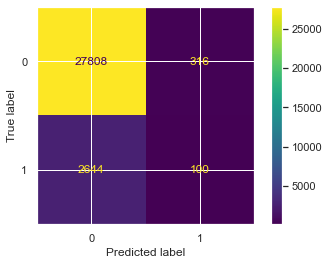

In [14]:
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f1)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()
plt.show()

In [15]:
experiment.log_metric("f1", f1)
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758a-a22-g3-projet/custom-models/282e56a58ce648e18778f8ab1b97efe8
COMET INFO:   Metrics:
COMET INFO:     f1 : 0.8706910353962992
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 100
COMET INFO:     learning_rate : 0.001
COMET INFO:     momentum      : 0.9
COMET INFO:     num_epochs    : 25
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (10.67 KB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook  